In [1]:
from graph import *
from models import *

In [2]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import plotly.graph_objects as go

In [3]:
detectors_run3 = pd.read_excel("cms_system_60.xlsx", sheet_name="Detectors")
triggers_run3 = pd.read_excel("cms_system_60.xlsx", sheet_name="Triggers")

In [4]:
detectors_run4 = pd.read_excel("cms_system_140.xlsx", sheet_name="Detectors")
triggers_run4 = pd.read_excel("cms_system_140.xlsx", sheet_name="Triggers")

In [5]:
detectors_run5 = pd.read_excel("cms_system_200.xlsx", sheet_name="Detectors")
triggers_run5 = pd.read_excel("cms_system_200.xlsx", sheet_name="Triggers")

In [6]:
detectors_fcchh = pd.read_excel("fcchh_system_950.xlsx", sheet_name="Detectors")
triggers_fcchh = pd.read_excel("fcchh_system_950.xlsx", sheet_name="Triggers")

In [7]:
detectors_fcchh

,Category,Detector,Data (bytes),Sample Rate,True Pass,True Discard,False Pass (alpha),False Discard (beta),Compression
0,Tracking,tracker_system,37500000,40000000,1,0,0,0,0
1,Calorimetry,calorimeter_system,5312500,40000000,1,0,0,0,0
2,Muon,muon_system,937500,40000000,1,0,0,0,0


In [8]:
triggers_fcchh

,Output,Name,Data (bytes),True Pass,True Discard,False Pass (alpha),False Discard (beta),Compression
0,Intermediate,Tracking,0,1,0.0,0,0,0
1,Intermediate,Calorimetry,0,1,0.0,0,0,0
2,Intermediate,Muon,0,1,0.0,0,0,0
3,Global,Intermediate,0,1,399.0,0,0,0
4,Disk,Global,0,1,13.3,0,0,0
5,NaN,Disk,0,1,0.0,0,0,0


In [9]:
cms_run3 = construct_graph(detectors_run3, triggers_run3)
cms_run4 = construct_graph(detectors_run4, triggers_run4)
cms_run5 = construct_graph(detectors_run5, triggers_run5)

In [10]:
year_run3 = 2023
year_run4 = 2028
year_run5 = 2032
year_fcchh = 2050

In [11]:
cms_run3.nodes["Disk"]

{'error matrix': [[0, 0], [0, 1]],
 'reduction': 1.0,
 'sample data': 0,
 'message size': 2000666.6666666667,
 'message rate': 1000.0}

In [12]:
cms_run3.edges[("Global", "Disk")]['throughput'] / 1e6

2000.6666666666667

In [13]:
cms_run4.nodes["Disk"]

{'error matrix': [[0, 0], [0, 1]],
 'reduction': 1.0,
 'sample data': 0,
 'message size': 6093000.0,
 'message rate': 5000.0}

In [14]:
cms_run4.edges[("Global", "Disk")]

{'throughput': 30465000000.0}

In [21]:
list(cms_run3.nodes)

['Inner Tracker',
 'Outer Tracker PS',
 'Outer Tracker 2S',
 'Track Finder TPG',
 'MIP Timing BTL',
 'MIP Timing ETL',
 'ECAL Barrel',
 'HCAL Barrel',
 'HCAL HO',
 'HCAL HF',
 'Muon DT',
 'Muon CSC',
 'Muon GEM GE1',
 'Muon GEM GE2',
 'Muon GEM ME0',
 'Muon RPC',
 'Tracking',
 'Timing',
 'Calorimetry',
 'Muon',
 'Intermediate',
 'Global',
 'Disk']

In [32]:
def lean_copy(graph: nx.classes.digraph):
    g = nx.DiGraph()
    for n in list(graph.nodes):
        g.add_node(n)

    for e in list(graph.edges):
        g.add_edge(*e)

    return g

In [34]:
g2 = lean_copy(cms_run3)

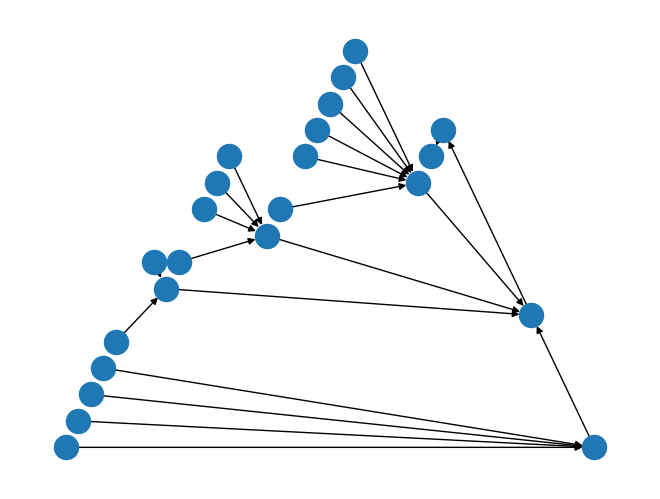

In [15]:
nx.draw_planar(cms_run3)

In [35]:
nx.write_gexf(g2, "cms.gexf")

In [ ]:
scaling = pd.read_excel("wall time scaling.xlsx", sheet_name="Data")

In [ ]:
fit_poly = lambda x, k3, k2, k1: k3 * x ** 3 + k2 * x ** 2 + k1 * x
k, cv = curve_fit(fit_poly, scaling["Pileup"], scaling["Wall Time"])

In [ ]:
power_lpgbt = (20 / 36) * (1 / 25e9)
power_100gbe = 2.5e-11

In [ ]:
cms_run3.edges[("Inner Tracker", "Tracking")]['throughput']

17466666666666.666

In [ ]:
def communication_power(graph: nx.classes.digraph):
    power_lpgbt = (20 / 36) * (1 / 25e9)
    power_100gbe = 2.5e-11

    #find intermediate inputs
    intermediate_inputs = list(graph.predecessors("Intermediate"))
    #power for links
    local_int_link = sum([graph.edges[(n, "Intermediate")]['throughput'] for n in intermediate_inputs]) * 8 * power_lpgbt
    int_global_link = graph.edges[("Intermediate", "Global")]['throughput'] * 8 * power_100gbe
    global_disk_link = graph.edges[("Global", "Disk")]['throughput'] * 8 * power_100gbe

    return local_int_link, int_global_link, global_disk_link


In [ ]:
def message_stats(graph: nx.classes.digraph):
    intermediate_inputs = list(graph.predecessors("Intermediate"))
    intermediate = sum([graph.nodes[n]["message size"] for n in intermediate_inputs])
    global_ = graph.nodes["Global"]["message size"]
    return intermediate, global_


In [ ]:
message_stats(cms_run3)

(1740666.6666666667, 2000666.6666666667)

In [ ]:
def processing_resources(baseline: nx.classes.digraph, future: nx.classes.digraph):
    base_int, base_global = message_stats(baseline)
    new_int, new_global = message_stats(future)

    ratio_int = new_int / base_int
    ratio_global = new_global / base_global
    return ratio_int, ratio_global


In [ ]:
def predict_demand(baseline, baseline_year, future, future_year):
    intermediate, global_ = processing_resources(baseline, future)
    global_ = fit_poly(60 * global_, *k)
    tech_scale = density_scale_model(future_year) / density_scale_model(baseline_year)
    intermediate /= tech_scale
    global_ /= tech_scale
    return intermediate, global_


In [ ]:
cms_run3.nodes["Muon"]['message size'] / (cms_run3.nodes["Muon"]['message size'] + cms_run3.nodes["Calorimetry"]['message size'])

0.3175735950044603

In [ ]:
cms_run4.nodes["Muon"]['message size'] / (cms_run4.nodes["Muon"]['message size'] + cms_run4.nodes["Calorimetry"]['message size'])

0.1508632889895273

In [ ]:
cms_run5.nodes["Muon"]['message size'] / (cms_run5.nodes["Muon"]['message size'] + cms_run5.nodes["Calorimetry"]['message size'])

0.15455475946775846

In [ ]:
mismatch_cernIT = [1.0, 2.5, 2.9]

In [ ]:
comms_power = np.stack([communication_power(g) for g in (cms_run3, cms_run4, cms_run5, fcchh)])

In [ ]:
comms_power

array([[1.23780741e+04, 4.00133333e+01, 4.00133333e-01],
       [4.14791111e+04, 1.21860000e+02, 6.09300000e+00],
       [5.80622222e+04, 1.68500000e+02, 1.17832168e+01],
       [3.11111111e+05, 8.75000000e+02, 6.11888112e+01]])

In [ ]:
communication_power(cms_run3)

(12378.074074074075, 40.013333333333335, 0.40013333333333334)

In [ ]:
communication_power(cms_run4)

(41479.11111111111, 121.86, 6.093)

In [ ]:
communication_power(cms_run5)

(58062.22222222222, 168.5, 11.783216783216782)

In [ ]:
compare_to_present = lambda x: predict_demand(cms_run3, year_run3, x[0], x[1])

In [ ]:
processing_demand = np.stack([compare_to_present(x) for x in [(cms_run3, year_run3), (cms_run4, year_run4), (cms_run5, year_run5), (fcchh, year_fcchh)]])

In [ ]:
processing_demand

array([[ 1.        ,  1.21386743],
       [ 1.31441962,  5.05228032],
       [ 0.8702507 ,  5.16781938],
       [ 0.16049957, 14.23902248]])

In [ ]:
base_l1t_power = 120e3
base_hlt_power = 1600e3
stage_power = np.array([base_l1t_power, base_hlt_power])

In [ ]:
processing_power = processing_demand * stage_power

In [ ]:
comms_power

array([[1.23780741e+04, 4.00133333e+01, 4.00133333e-01],
       [4.14791111e+04, 1.21860000e+02, 6.09300000e+00],
       [5.80622222e+04, 1.68500000e+02, 1.17832168e+01],
       [3.11111111e+05, 8.75000000e+02, 6.11888112e+01]])

In [ ]:
all_power = np.concatenate((comms_power, processing_power), axis=1)

In [ ]:
labels = ["CMS Run 3", "CMS Run 4", "CMS Run 5", "FCC-hh"]

In [ ]:
total_power = np.sum(all_power, axis=1)

In [ ]:
fig = go.Figure(data = [
    go.Bar(name="Phase-1 Pipeline", x=labels, y=total_power),
    #go.Bar(name="Smart Pixels Pipeline", x=experiments, y=total_energy_smartpx),

])
fig.update_layout(
                  xaxis_title="Experiment",
                  yaxis_title="Total DAQ Power (W)",
                  width = 900,
                  height = 600,)
fig.show()
fig.write_image("experiment comparison.png")

In [ ]:
total_power

array([ 2074606.37160883,  8282985.92858345,  8431183.60029054,
       23113743.21834113])